In [ ]:
!pip install xgboost

In [ ]:
!pip install pycaret

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires scikit-learn>=0.24.0, but you have scikit-learn 0.23.2 which is incompatible.
sktime 0.8.1 requires statsmodels<=0.12.1, 

In [ ]:
pip install sktime

  Using cached scikit_learn-1.0.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.2 MB)
     |████████████████████████████████| 9.5 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires statsmodels<=0.12.1, but you have statsmodels 0.13.0 which is incompatible.
pycaret 2.3.4 requires scikit-learn==0.23.2, but you have scikit-learn 1.0.1 which is incompatible.


In [ ]:
pip install shap

In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm import tqdm
import warnings
import scipy 
import lightgbm as lgb
import xgboost as xgb
import sktime
import sklearn as skl
from pycaret.regression import *
warnings.filterwarnings(action='ignore')
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '가스수요량'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import plotly.express as px
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%matplotlib inline 
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/가스수요량


In [ ]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv',  header=0, encoding='cp949')
temper = pd.read_csv('서울기온.csv', error_bad_lines=False)
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
rain = pd.read_csv('강수량.csv', error_bad_lines=False)
wind = pd.read_csv('풍속.csv', error_bad_lines=False)

In [ ]:
rain = rain[['일시','last_rain']]
#rain = rain.rename({'일시':'연월일'},axis = 1)
wind = wind[['일시','last_avg_windspeed','last_max_windspeed']]
#wind = wind.rename({'일시':'연월일'},axis = 1)

In [ ]:
rain.head()#전일 강수량

,일시,last_rain
0,2012-01-01,NaN
1,2012-01-02,0.0
2,2012-01-03,0.0
3,2012-01-04,0.4
4,2012-01-05,0.0


In [ ]:
wind.head()#전일 평균 풍속, 전일 최대 풍속

,일시,last_avg_windspeed,last_max_windspeed
0,2012-01-01,NaN,NaN
1,2012-01-02,2.9,12.6
2,2012-01-03,2.3,6.1
3,2012-01-04,2.5,10.3
4,2012-01-05,3.1,8.7


In [ ]:
wind["일시"]=wind["일시"].astype(str)
rain["일시"]=rain["일시"].astype(str)
weather = pd.merge(wind, rain, on = '일시')
weather["일시"] = pd.to_datetime(weather['일시'])

In [ ]:
weather

,일시,last_avg_windspeed,last_max_windspeed,last_rain
0,2012-01-01,NaN,NaN,NaN
1,2012-01-02,2.9,12.6,0.0
2,2012-01-03,2.3,6.1,0.0
3,2012-01-04,2.5,10.3,0.4
4,2012-01-05,3.1,8.7,0.0
...,...,...,...,...
2917,2019-12-27,2.4,9.0,0.3
2918,2019-12-28,2.1,7.7,0.0
2919,2019-12-29,2.0,5.8,0.0
2920,2019-12-30,2.9,6.6,1.4


In [ ]:
temper.head()

,지점번호,지점명,일시,평균기온(℃),최고기온(℃),최고기온시각,최저기온(℃),최저기온시각,일교차,last_avg_temperture,last_low_temperture,last_high_temperture
0,108,서울,2012-01-01,-3.0,0.4,0:01,-6.9,23:26,",7.3",NaN,NaN,NaN
1,108,서울,2012-01-02,-4.8,-1.2,13:57,-8.3,7:58,",7.1",-6.9,-3.0,0.4
2,108,서울,2012-01-03,-4.5,-0.2,12:52,-6.8,7:52,",6.6",-8.3,-4.8,-1.2
3,108,서울,2012-01-04,-7.4,-4.3,15:52,-9.6,8:37,",5.3",-6.8,-4.5,-0.2
4,108,서울,2012-01-05,-5.7,-1.3,15:42,-9.8,7:40,",8.5",-9.6,-7.4,-4.3


In [ ]:
temper = temper[["일시","last_avg_temperture","last_low_temperture", "last_high_temperture"]]
weather['일시'] =  weather['일시'].astype(str)
temper["일시"] = temper["일시"].astype(str)
weather = pd.merge(weather, temper, on = '일시')
weather = weather.rename({"일시":"d"},axis = 1)


In [ ]:
weather.head()

,d,last_avg_windspeed,last_max_windspeed,last_rain,last_avg_temperture,last_low_temperture,last_high_temperture
0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,2.9,12.6,0.0,-6.9,-3.0,0.4
2,2012-01-03,2.3,6.1,0.0,-8.3,-4.8,-1.2
3,2012-01-04,2.5,10.3,0.4,-6.8,-4.5,-0.2
4,2012-01-05,3.1,8.7,0.0,-9.6,-7.4,-4.3


In [ ]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [ ]:
test['d'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['station'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test

,일자|시간|구분,d,hour,station
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [ ]:
test = pd.merge(weather, test, on = 'd').drop('일자|시간|구분',axis = 1)

In [ ]:
test.head()

,d,last_avg_windspeed,last_max_windspeed,last_rain,last_avg_temperture,last_low_temperture,last_high_temperture,hour,station
0,2019-01-01,1.2,5.7,0.0,-10.5,-5.4,-0.5,1,A
1,2019-01-01,1.2,5.7,0.0,-10.5,-5.4,-0.5,2,A
2,2019-01-01,1.2,5.7,0.0,-10.5,-5.4,-0.5,3,A
3,2019-01-01,1.2,5.7,0.0,-10.5,-5.4,-0.5,4,A
4,2019-01-01,1.2,5.7,0.0,-10.5,-5.4,-0.5,5,A


In [ ]:
total.columns = ["d", "hour", "station","gas_need"]
total = pd.merge(weather, total, on = 'd')


In [ ]:
total.head()

,d,last_avg_windspeed,last_max_windspeed,last_rain,last_avg_temperture,last_low_temperture,last_high_temperture,hour,station,gas_need
0,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,-5.0,1,A,2497.129
1,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,-5.0,2,A,2363.265
2,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,-5.0,3,A,2258.505
3,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,-5.0,4,A,2243.969
4,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,-5.0,5,A,2344.105


In [ ]:
d_map = {}
for i, d in enumerate(total['station'].unique()):
    d_map[d] = i
total['station'] = total['station'].map(d_map)
test['station'] = test['station'].map(d_map)

Preprocessing

In [ ]:
def preprocessing(train_df):
  # 시간정보 디코딩
  date = pd.to_datetime(train_df.d)
  train_df['day'] = date.dt.weekday
  train_df['month'] = date.dt.month
  train_df['week'] = date.dt.weekofyear
  train_df['year'] = date.dt.year

  # hour는 주기적 정보로, 23이 0보다 수치적으로 큰 의미를 갖지 않고, 반복되는 특징을 갖고 때문에 초월함수 수치형으로 인코딩한다. 
  train_df['sin_time'] = np.sin(train_df['hour']/24*2*np.pi)
  train_df['cos_time'] = np.cos(train_df['hour']/24*2*np.pi)

  # 불쾌지수 - 열받으면 에어컨을 더 자주 틀겠지. 
  train_df['last_Windchill'] = 13.12 + 0.6215 * (train_df['last_avg_temperture']) - 11.37 * (train_df['last_avg_windspeed'])**0.16 + 0.3965 * (train_df['last_avg_windspeed']**16) * (train_df['last_avg_temperture'])
  # 공휴일 
  train_df['holiday'] = train_df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
  #2013년
  #1월
  train_df.loc[('2013-01-01'<=train_df.d)&(train_df.d<'2013-01-02'), 'holiday'] = 1 #신정
  #2월
  train_df.loc[('2013-02-09'<=train_df.d)&(train_df.d<'2013-02-10'), 'holiday'] = 1 #설날
  train_df.loc[('2013-02-10'<=train_df.d)&(train_df.d<'2013-02-11'), 'holiday'] = 1 #설날
  train_df.loc[('2013-02-11'<=train_df.d)&(train_df.d<'2013-02-12'), 'holiday'] = 1 #설날
  #3월
  train_df.loc[('2013-03-01'<=train_df.d)&(train_df.d<'2013-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2013-05-05'<=train_df.d)&(train_df.d<'2013-05-06'), 'holiday'] = 1 #어린이날
  train_df.loc[('2013-05-17'<=train_df.d)&(train_df.d<'2013-05-18'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2013-06-06'<=train_df.d)&(train_df.d<'2013-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2013-08-15'<=train_df.d)&(train_df.d<'2013-08-16'), 'holiday'] = 1 #광복
  #9월
  train_df.loc[('2013-09-18'<=train_df.d)&(train_df.d<'2013-09-19'), 'holiday'] = 1 #추석
  train_df.loc[('2013-09-19'<=train_df.d)&(train_df.d<'2013-09-20'), 'holiday'] = 1 #추석
  train_df.loc[('2013-09-20'<=train_df.d)&(train_df.d<'2013-09-21'), 'holiday'] = 1 #추석
  #10월
  train_df.loc[('2013-10-03'<=train_df.d)&(train_df.d<'2013-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2013-10-09'<=train_df.d)&(train_df.d<'2013-10-01'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2013-12-25'<=train_df.d)&(train_df.d<'2013-12-26'), 'holiday'] = 1 #크리스마스
  
  #2014년
  #1월
  train_df.loc[('2014-01-01'<=train_df.d)&(train_df.d<'2014-01-02'), 'holiday'] = 1 #신정
  train_df.loc[('2014-01-30'<=train_df.d)&(train_df.d<'2014-01-31'), 'holiday'] = 1 #설날
  train_df.loc[('2014-01-31'<=train_df.d)&(train_df.d<'2014-02-01'), 'holiday'] = 1 #설날
  #2월
  train_df.loc[('2014-02-01'<=train_df.d)&(train_df.d<'2014-02-02'), 'holiday'] = 1 #설날
  #3월
  train_df.loc[('2014-03-01'<=train_df.d)&(train_df.d<'2014-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2014-05-05'<=train_df.d)&(train_df.d<'2014-05-06'), 'holiday'] = 1 #어린이날
  train_df.loc[('2014-05-06'<=train_df.d)&(train_df.d<'2014-05-07'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2014-06-06'<=train_df.d)&(train_df.d<'2014-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2014-08-15'<=train_df.d)&(train_df.d<'2014-08-16'), 'holiday'] = 1 #광복
  #9월
  train_df.loc[('2014-09-08'<=train_df.d)&(train_df.d<'2014-09-09'), 'holiday'] = 1 #추석
  train_df.loc[('2014-09-09'<=train_df.d)&(train_df.d<'2014-09-10'), 'holiday'] = 1 #추석
  train_df.loc[('2014-09-10'<=train_df.d)&(train_df.d<'2014-09-11'), 'holiday'] = 1 #추석 대체
  #10월
  train_df.loc[('2014-10-03'<=train_df.d)&(train_df.d<'2014-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2014-10-09'<=train_df.d)&(train_df.d<'2014-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2014-12-25'<=train_df.d)&(train_df.d<'2014-12-26'), 'holiday'] = 1 #크리스마스

  #2015년
  #1월
  train_df.loc[('2015-01-01'<=train_df.d)&(train_df.d<'2015-01-02'), 'holiday'] = 1 #신정
  #2월
  train_df.loc[('2015-02-18'<=train_df.d)&(train_df.d<'2015-01-19'), 'holiday'] = 1 #설날
  train_df.loc[('2015-02-19'<=train_df.d)&(train_df.d<'2015-02-20'), 'holiday'] = 1 #설날
  train_df.loc[('2015-02-20'<=train_df.d)&(train_df.d<'2015-02-21'), 'holiday'] = 1 #설날
  #3월
  train_df.loc[('2015-03-01'<=train_df.d)&(train_df.d<'2015-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2015-05-05'<=train_df.d)&(train_df.d<'2015-05-06'), 'holiday'] = 1 #어린이날
  train_df.loc[('2015-05-25'<=train_df.d)&(train_df.d<'2015-05-26'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2015-06-06'<=train_df.d)&(train_df.d<'2015-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2015-08-14'<=train_df.d)&(train_df.d<'2015-08-15'), 'holiday'] = 1 #임시휴일
  train_df.loc[('2015-08-15'<=train_df.d)&(train_df.d<'2015-08-16'), 'holiday'] = 1 #광복절
  #9월
  train_df.loc[('2015-09-26'<=train_df.d)&(train_df.d<'2015-09-27'), 'holiday'] = 1 #추석
  train_df.loc[('2015-09-27'<=train_df.d)&(train_df.d<'2015-09-28'), 'holiday'] = 1 #추석
  train_df.loc[('2015-09-28'<=train_df.d)&(train_df.d<'2015-09-29'), 'holiday'] = 1 #추석
  train_df.loc[('2015-09-29'<=train_df.d)&(train_df.d<'2015-09-30'), 'holiday'] = 1 #추석대체
  #10월
  train_df.loc[('2015-10-03'<=train_df.d)&(train_df.d<'2015-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2015-10-09'<=train_df.d)&(train_df.d<'2015-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2015-12-25'<=train_df.d)&(train_df.d<'2015-12-26'), 'holiday'] = 1 #크리스마스

  #2016년
  #1월
  train_df.loc[('2016-01-01'<=train_df.d)&(train_df.d<'2016-01-02'), 'holiday'] = 1 #신정
  #2월
  train_df.loc[('2016-02-08'<=train_df.d)&(train_df.d<'2016-01-09'), 'holiday'] = 1 #설날
  train_df.loc[('2016-02-09'<=train_df.d)&(train_df.d<'2016-02-10'), 'holiday'] = 1 #설날
  train_df.loc[('2016-02-10'<=train_df.d)&(train_df.d<'2016-02-11'), 'holiday'] = 1 #설날대체
  #3월
  train_df.loc[('2016-03-01'<=train_df.d)&(train_df.d<'2016-03-02'), 'holiday'] = 1 #3.1절
  #4월
  train_df.loc[('2016-04-13'<=train_df.d)&(train_df.d<'2016-04-14'), 'holiday'] = 1 #국회의원 선거일
  #5월
  train_df.loc[('2016-05-06'<=train_df.d)&(train_df.d<'2016-05-07'), 'holiday'] = 1 #어린이날대체
  train_df.loc[('2016-05-14'<=train_df.d)&(train_df.d<'2016-05-15'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2016-06-06'<=train_df.d)&(train_df.d<'2016-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2016-08-15'<=train_df.d)&(train_df.d<'2016-08-16'), 'holiday'] = 1 #광복절
  #9월
  train_df.loc[('2016-09-14'<=train_df.d)&(train_df.d<'2016-09-15'), 'holiday'] = 1 #추석
  train_df.loc[('2016-09-15'<=train_df.d)&(train_df.d<'2016-09-16'), 'holiday'] = 1 #추석
  train_df.loc[('2016-09-16'<=train_df.d)&(train_df.d<'2016-09-17'), 'holiday'] = 1 #추석
  #10월
  train_df.loc[('2016-10-03'<=train_df.d)&(train_df.d<'2016-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2016-10-09'<=train_df.d)&(train_df.d<'2016-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2016-12-25'<=train_df.d)&(train_df.d<'2016-12-26'), 'holiday'] = 1 #크리스마스
  
  #2017년
  #1월
  train_df.loc[('2017-01-01'<=train_df.d)&(train_df.d<'2017-01-02'), 'holiday'] = 1 #신정
  train_df.loc[('2017-01-27'<=train_df.d)&(train_df.d<'2017-01-28'), 'holiday'] = 1 #설날
  train_df.loc[('2017-01-28'<=train_df.d)&(train_df.d<'2017-01-29'), 'holiday'] = 1 #설날
  train_df.loc[('2017-01-29'<=train_df.d)&(train_df.d<'2017-01-30'), 'holiday'] = 1 #설날
  train_df.loc[('2017-01-30'<=train_df.d)&(train_df.d<'2017-01-31'), 'holiday'] = 1 #설날대체
  #2월
  #3월
  train_df.loc[('2017-03-01'<=train_df.d)&(train_df.d<'2017-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2017-05-05'<=train_df.d)&(train_df.d<'2017-05-06'), 'holiday'] = 1 #어린이날대체
  train_df.loc[('2017-05-03'<=train_df.d)&(train_df.d<'2017-05-04'), 'holiday'] = 1 #석가탄신일
  train_df.loc[('2017-05-09'<=train_df.d)&(train_df.d<'2017-05-10'), 'holiday'] = 1 #대통선거
  #6월
  train_df.loc[('2017-06-06'<=train_df.d)&(train_df.d<'2017-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2017-08-15'<=train_df.d)&(train_df.d<'2017-08-16'), 'holiday'] = 1 #광복절
  #9월
  #10월
  train_df.loc[('2017-10-02'<=train_df.d)&(train_df.d<'2017-10-03'), 'holiday'] = 1 #임시공휴일
  train_df.loc[('2017-10-03'<=train_df.d)&(train_df.d<'2017-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2017-10-04'<=train_df.d)&(train_df.d<'2017-10-05'), 'holiday'] = 1 #추석
  train_df.loc[('2017-10-05'<=train_df.d)&(train_df.d<'2017-10-06'), 'holiday'] = 1 #대체공휴일
  train_df.loc[('2017-10-09'<=train_df.d)&(train_df.d<'2017-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2017-12-25'<=train_df.d)&(train_df.d<'2017-12-26'), 'holiday'] = 1 #크리스마스

  #2018년
  #1월
  train_df.loc[('2018-01-01'<=train_df.d)&(train_df.d<'2018-01-02'), 'holiday'] = 1 #신정
  #2월
  train_df.loc[('2018-02-15'<=train_df.d)&(train_df.d<'2018-02-16'), 'holiday'] = 1 #설날
  train_df.loc[('2018-02-16'<=train_df.d)&(train_df.d<'2018-02-17'), 'holiday'] = 1 #설날
  train_df.loc[('2018-02-17'<=train_df.d)&(train_df.d<'2018-02-18'), 'holiday'] = 1 #설날
  #3월
  train_df.loc[('2018-03-01'<=train_df.d)&(train_df.d<'2018-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2018-05-07'<=train_df.d)&(train_df.d<'2018-05-08'), 'holiday'] = 1 #어린이날대체
  train_df.loc[('2018-05-22'<=train_df.d)&(train_df.d<'2018-05-23'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2018-06-06'<=train_df.d)&(train_df.d<'2018-06-07'), 'holiday'] = 1 #현충일
  train_df.loc[('2018-06-13'<=train_df.d)&(train_df.d<'2018-06-14'), 'holiday'] = 1 #지방선거
  #7월
  #8월
  train_df.loc[('2018-08-15'<=train_df.d)&(train_df.d<'2018-08-16'), 'holiday'] = 1 #광복절
  #9월
  train_df.loc[('2018-09-24'<=train_df.d)&(train_df.d<'2018-09-25'), 'holiday'] = 1 #추석
  train_df.loc[('2018-09-25'<=train_df.d)&(train_df.d<'2018-09-26'), 'holiday'] = 1 #추석
  train_df.loc[('2018-09-26'<=train_df.d)&(train_df.d<'2018-09-27'), 'holiday'] = 1 #대체
  #10월
  train_df.loc[('2018-10-03'<=train_df.d)&(train_df.d<'2018-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2018-10-09'<=train_df.d)&(train_df.d<'2018-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2018-12-25'<=train_df.d)&(train_df.d<'2018-12-26'), 'holiday'] = 1 #크리스마스

  #2019년
  #1월
  train_df.loc[('2019-01-01'<=train_df.d)&(train_df.d<'2019-01-02'), 'holiday'] = 1 #신정
  #2월
  train_df.loc[('2019-02-04'<=train_df.d)&(train_df.d<'2019-02-05'), 'holiday'] = 1 #설날
  train_df.loc[('2019-02-05'<=train_df.d)&(train_df.d<'2019-02-06'), 'holiday'] = 1 #설날
  train_df.loc[('2019-02-06'<=train_df.d)&(train_df.d<'2019-02-07'), 'holiday'] = 1 #설날
  #3월
  train_df.loc[('2019-03-01'<=train_df.d)&(train_df.d<'2019-03-02'), 'holiday'] = 1 #3.1절
  #4월
  #5월
  train_df.loc[('2019-05-06'<=train_df.d)&(train_df.d<'2019-05-07'), 'holiday'] = 1 #어린이날대체
  train_df.loc[('2019-05-12'<=train_df.d)&(train_df.d<'2019-05-13'), 'holiday'] = 1 #석가탄신일
  #6월
  train_df.loc[('2019-06-06'<=train_df.d)&(train_df.d<'2019-06-07'), 'holiday'] = 1 #현충일
  #7월
  #8월
  train_df.loc[('2019-08-15'<=train_df.d)&(train_df.d<'2019-08-16'), 'holiday'] = 1 #광복절
  #9월
  train_df.loc[('2019-09-12'<=train_df.d)&(train_df.d<'2019-09-13'), 'holiday'] = 1 #추석
  train_df.loc[('2019-09-13'<=train_df.d)&(train_df.d<'2019-09-14'), 'holiday'] = 1 #추석
  train_df.loc[('2019-09-14'<=train_df.d)&(train_df.d<'2019-09-15'), 'holiday'] = 1 #대체
  #10월
  train_df.loc[('2019-10-03'<=train_df.d)&(train_df.d<'2019-10-04'), 'holiday'] = 1 #개천절
  train_df.loc[('2019-10-09'<=train_df.d)&(train_df.d<'2019-10-10'), 'holiday'] = 1 #한글날
  #11월
  #12월
  train_df.loc[('2019-12-25'<=train_df.d)&(train_df.d<'2019-12-26'), 'holiday'] = 1 #크리스마스

  return train_df

In [ ]:
df = preprocessing(total).drop('d',axis = 1)
test = preprocessing(test).drop('d',axis = 1)

In [ ]:
df

,last_avg_windspeed,last_max_windspeed,last_rain,last_avg_temperture,last_low_temperture,last_high_temperture,hour,station,gas_need,day,month,week,year,sin_time,cos_time,last_Windchill,holiday
0,2.2,6.5,0.0,-11.6,-8.7,-5.0,1,0,2497.129,1,1,1,2013,2.588190e-01,0.965926,-1.385053e+06,1
1,2.2,6.5,0.0,-11.6,-8.7,-5.0,2,0,2363.265,1,1,1,2013,5.000000e-01,0.866025,-1.385053e+06,1
2,2.2,6.5,0.0,-11.6,-8.7,-5.0,3,0,2258.505,1,1,1,2013,7.071068e-01,0.707107,-1.385053e+06,1
3,2.2,6.5,0.0,-11.6,-8.7,-5.0,4,0,2243.969,1,1,1,2013,8.660254e-01,0.500000,-1.385053e+06,1
4,2.2,6.5,0.0,-11.6,-8.7,-5.0,5,0,2344.105,1,1,1,2013,9.659258e-01,0.258819,-1.385053e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,1.2,5.6,0.0,-11.3,-6.8,-0.9,20,6,681.033,0,12,1,2018,-8.660254e-01,0.500000,-8.844598e+01,0
368084,1.2,5.6,0.0,-11.3,-6.8,-0.9,21,6,669.961,0,12,1,2018,-7.071068e-01,0.707107,-8.844598e+01,0
368085,1.2,5.6,0.0,-11.3,-6.8,-0.9,22,6,657.941,0,12,1,2018,-5.000000e-01,0.866025,-8.844598e+01,0
368086,1.2,5.6,0.0,-11.3,-6.8,-0.9,23,6,610.953,0,12,1,2018,-2.588190e-01,0.965926,-8.844598e+01,0


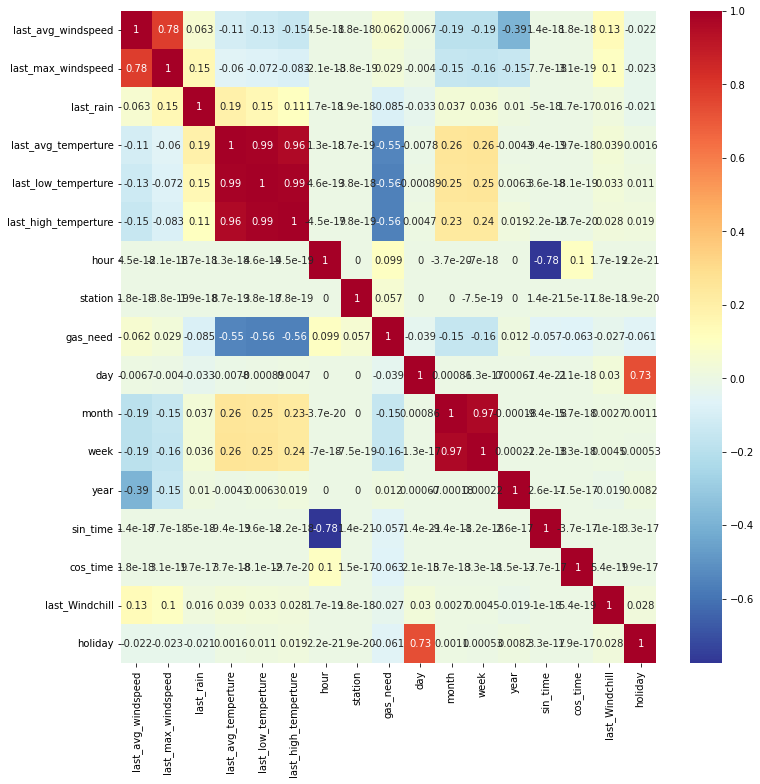

In [ ]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(),annot = True, cmap = 'RdYlBu_r')
plt.show()

In [ ]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]
train = df[df['year'].isin(train_years)]
val = df[df['year'].isin(val_years)]

In [ ]:
model1 = setup(train, target = 'gas_need', session_id=970629, log_experiment=True, experiment_name='AUTO')


,Description,Value
0,session_id,970629
1,Target,gas_need
2,Original Data,"(306768, 17)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(214737, 43)"


AttributeError: ignored

In [ ]:
best_model=pycaret.regression.compare_models(fold = 5, sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.720540e+01,6.731293e+03,8.159000e+01,9.918000e-01,0.0806,5.050000e-02,60.470
rf,Random Forest Regressor,4.062200e+01,7.282179e+03,8.500520e+01,9.912000e-01,0.0971,6.150000e-02,67.918
lightgbm,Light Gradient Boosting Machine,6.420400e+01,1.133357e+04,1.062650e+02,9.862000e-01,0.3484,5.350000e-01,1.498
dt,Decision Tree Regressor,5.674240e+01,1.458229e+04,1.204230e+02,9.823000e-01,0.1065,6.840000e-02,1.514
gbr,Gradient Boosting Regressor,1.174654e+02,3.408270e+04,1.845499e+02,9.586000e-01,0.4644,6.997000e-01,18.706
ridge,Ridge Regression,3.012823e+02,1.599891e+05,3.999788e+02,8.057000e-01,0.8166,2.463700e+00,0.078
lasso,Lasso Regression,3.005986e+02,1.604368e+05,4.005382e+02,8.052000e-01,0.8115,2.423200e+00,5.862
omp,Orthogonal Matching Pursuit,3.743121e+02,2.360970e+05,4.858221e+02,7.134000e-01,0.8645,2.474200e+00,0.116
ada,AdaBoost Regressor,4.975481e+02,3.566079e+05,5.956446e+02,5.668000e-01,1.1588,5.002900e+00,9.276
en,Elastic Net,4.525777e+02,4.005701e+05,6.328995e+02,5.136000e-01,0.9380,2.947900e+00,6.814


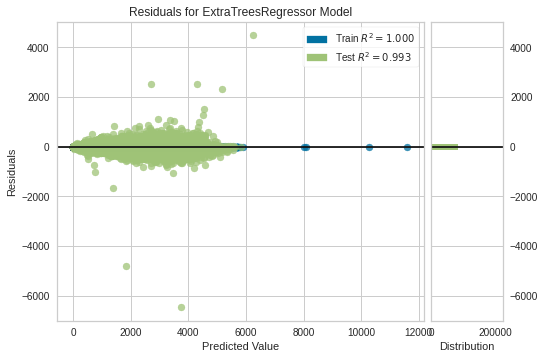

In [ ]:
pycaret.regression.plot_model(best_model)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
best_model= ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                    oob_score=False, random_state=970629, verbose=0,
                    warm_start=False)

In [ ]:
train_x = train[["last_avg_windspeed","last_max_windspeed","last_rain","last_avg_temperture","last_low_temperture","last_high_temperture","hour","station","day","month","week","year","sin_time","cos_time","last_Windchill","holiday"]]
train_y = train["gas_need"]
val_x = val[["last_avg_windspeed","last_max_windspeed","last_rain","last_avg_temperture","last_low_temperture","last_high_temperture","hour","station","day","month","week","year","sin_time","cos_time","last_Windchill","holiday"]]
val_y = val["gas_need"]

In [ ]:
best_model.fit(train_x,train_y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                    oob_score=False, random_state=970629, verbose=0,
                    warm_start=False)

In [ ]:
pred_val = best_model.predict(val_x)

In [ ]:
val_y

306768    1765.008
306769    1679.186
306770    1610.885
306771    1604.123
306772    1711.506
            ...   
368083     681.033
368084     669.961
368085     657.941
368086     610.953
368087     560.896
Name: gas_need, Length: 61320, dtype: float64

In [ ]:
pred_val

array([1784.64592, 1543.54285, 1433.24089, ...,  658.12393,  610.19902,
        553.95458])

In [ ]:
pred_test = best_model.predict(test)
submission['공급량'] = pred_test
submission.to_csv("/content/drive/MyDrive/AUTOML_PRATICE.csv", index = False)

In [ ]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,2152.69961
1,2019-01-01 02 A,1950.85191
2,2019-01-01 03 A,1828.98065
3,2019-01-01 04 A,1870.35421
4,2019-01-01 05 A,2021.67484
...,...,...
15115,2019-03-31 20 H,488.24557
15116,2019-03-31 21 H,485.97409
15117,2019-03-31 22 H,456.55922
15118,2019-03-31 23 H,411.87568


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
x_train_sets = []
x_valid_sets = []
x_test_sets = []
y_train_sets = []
y_valid_sets = []
y_test_sets = []

for i in tqdm(range(7)):
  temp_train =  train[train.station == i]
  temp_test = test[test.station == i]
  y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = temp_train['gas_need'] , 
                                                                 X = temp_train.drop(['gas_need','station'],axis = 1),
                                                                 test_size = 168) # 마지막 일주일
  x_train_sets.append(x_train)
  y_train_sets.append(y_train)
  x_valid_sets.append(x_valid)
  y_valid_sets.append(y_valid)                                                               
  x_test_sets.append(temp_test.drop(['station'], axis = 1))

100%|██████████| 7/7 [00:00<00:00, 68.51it/s]


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
from lightgbm import LGBMRegressor

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch1-Time-Series.html#smape-symmetric-mean-absolute-percentage-error
#과대추정이 과소추정보다 패널티가 적은 LOSS
add_metric('SMAPE','SMAPE',SMAPE ,greater_is_better=False)
model_sets = []
scores = []

lgbm_mae_params = {
    'objective': 'RMSE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
} #lightgbm hyper parameter

for i in range(7):
  x_train = x_train_sets[i]
  y_train = y_train_sets[i]
  x_valid = x_valid_sets[i]
  x_valid = x_valid_sets[i]
  regressor = LGBMRegressor(**lgbm_mae_params)
  regressor.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100) 
  valid_pred = regressor.predict(x_valid)
  score = SMAPE(y_valid, valid_pred)
  scores.append(score)
  model_sets.append(regressor)

[100]	valid_0's rmse: 275.732


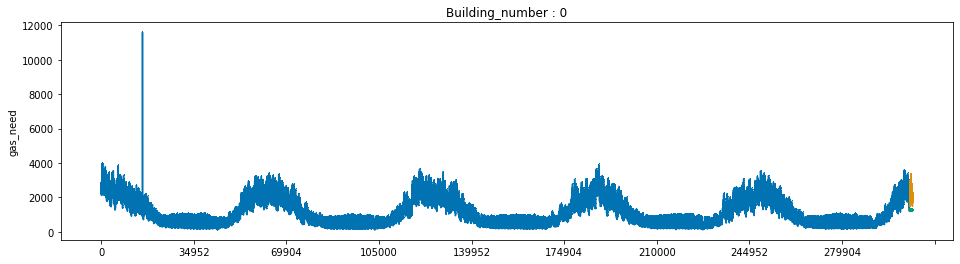

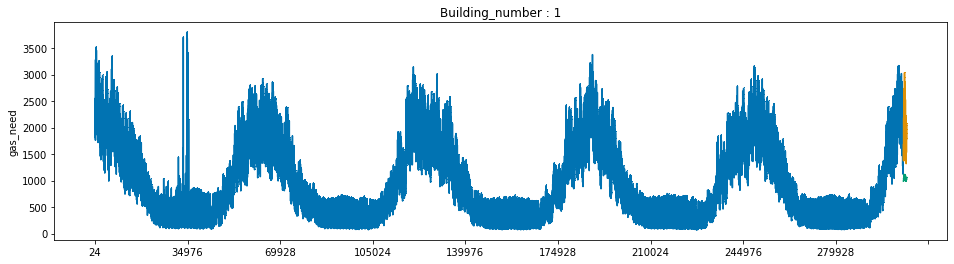

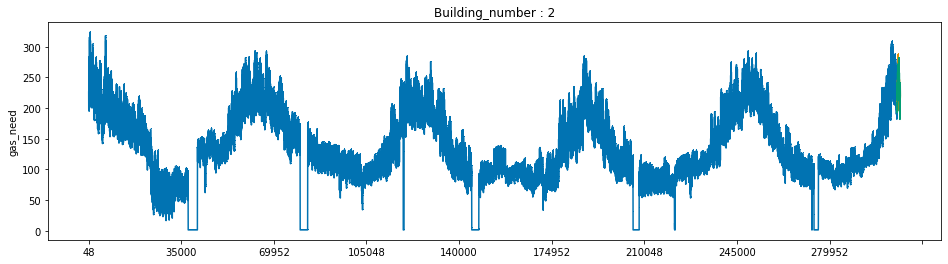

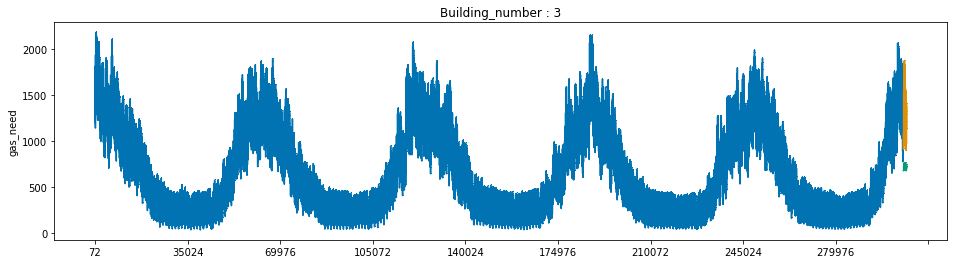

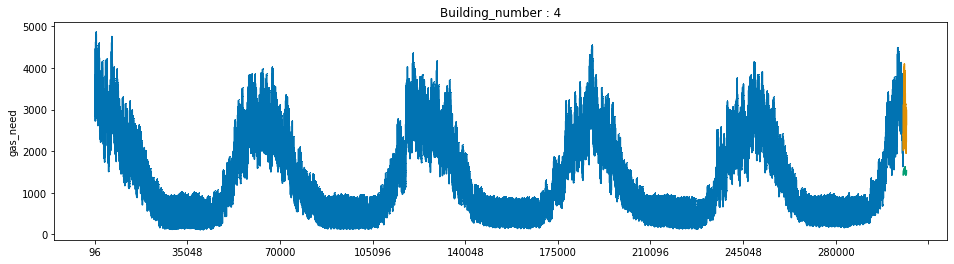

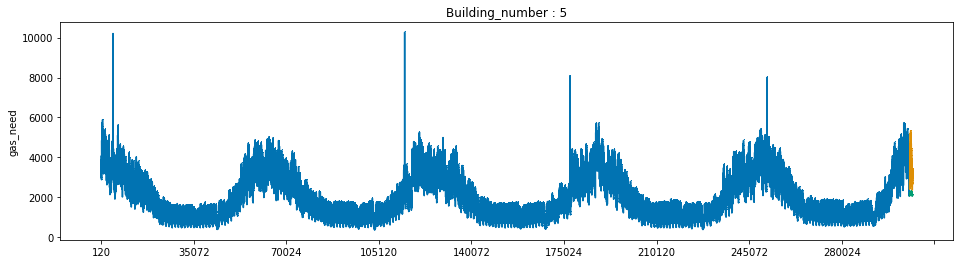

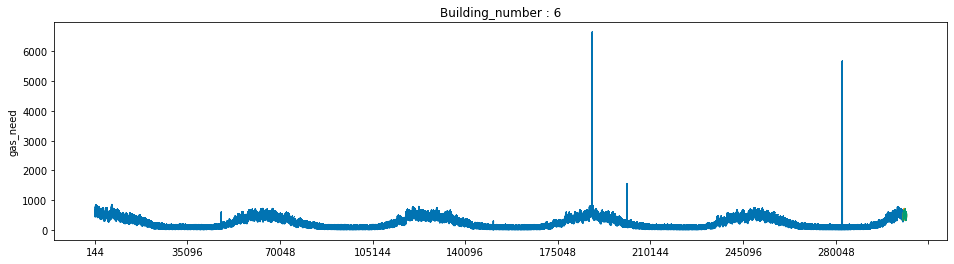

In [ ]:
for i in range(7):
  temp = pd.Series(model_sets[i].predict(x_valid_sets[i]))
  temp.index = y_valid_sets[i].index
  plot_series(y_train_sets[i],y_valid_sets[i], temp,markers = [',',',',','])
  plt.title("Building_number : "+str(i))

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma ,min_child_weight, subsample
           ,colsample_bytree, silent=True, nthread=-1):

      # 모델 정의
      model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread,
                                objective = 'reg:squarederror'
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)

      # 각종 metric 계산
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      smape = SMAPE(y_test, y_pred)
      # 오차 최적화로 사용할 metric 반환
      return -smape

In [ ]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization

X_train = x_train_sets[1]
y_train = y_train_sets[1]
X_test = x_valid_sets[1]
y_test = y_valid_sets[1]

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 17),
           'learning_rate': (0.01, 0.2),
           'n_estimators': (50, 500),
           'gamma': (0, 130),
           'min_child_weight': (1, 10),
           'subsample': (0.5, 1),
           'colsample_bytree' :(0.2, 1),
            }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 ,)    

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다
# 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.71    |  0.5336   |  93.64    |  0.01002  |  7.233    |  2.321    |  91.55    |  0.5931   |
|  2        | -3.178    |  0.4764   |  51.58    |  0.1124   |  8.869    |  7.167    |  142.0    |  0.9391   |
|  3        | -2.227    |  0.3954   |  52.86    |  0.1983   |  7.163    |  5.743    |  143.0    |  0.7931   |
|  4        | -3.312    |  0.2      |  57.11    |  0.2      |  3.0      |  1.0      |  164.3    |  0.5      |
|  5        | -3.303    |  0.2      |  70.75    |  0.2      |  3.0      |  1.0      |  148.9    |  0.5      |
|  6        | -3.297    |  0.2      |  11.44    |  0.2      |  3.0      |  1.0      |  154.0    |  0.5      |
|  7        | -3.244    |  0.2      |  0.0      |  0.2      |  3.0      |  1.0      |  204.2    |  0.5      |
|  8      

In [ ]:
def BayesianOpt():
  optimized_params = []
  pbounds = {'max_depth': (3, 17),
           'learning_rate': (0.01, 0.1),
           'n_estimators': (50, 500),
           'gamma': (0, 150),
           'min_child_weight': (1, 10),
           'subsample': (0.5, 1),
           'colsample_bytree' :(0.2, 1),
            }
  for i in tqdm(range(7)):
    print('\n')
    def XGB_cv(max_depth,learning_rate, n_estimators, gamma
           ,min_child_weight, subsample
           ,colsample_bytree, silent=True, nthread=-1):
      model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread,
                                objective = 'reg:squarederror'
                                )
      model.fit(X_train, y_train)
      y_pred= model.predict(X_test)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      smape = SMAPE(y_test, y_pred)
      return -smape
    X_train = x_train_sets[i]
    y_train = y_train_sets[i]
    X_test = x_valid_sets[i]
    y_test = y_valid_sets[i]
    bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    
    bo.maximize(init_points=2, n_iter=30, acq='ei', xi=0.01)
    optimized_params.append(bo.max)
  return optimized_params

In [ ]:
optimized_params = BayesianOpt()

  0%|          | 0/7 [00:00<?, ?it/s]



|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.99    |  0.5336   |  108.0    |  0.01001  |  7.233    |  2.321    |  91.55    |  0.5931   |
|  2        | -2.739    |  0.4764   |  59.52    |  0.05849  |  8.869    |  7.167    |  142.0    |  0.9391   |
|  3        | -3.166    |  0.3954   |  60.99    |  0.09919  |  7.163    |  5.743    |  143.0    |  0.7931   |
|  4        | -13.03    |  0.8184   |  32.83    |  0.01     |  17.0     |  10.0     |  158.5    |  1.0      |
|  5        | -20.23    |  0.2      |  50.62    |  0.01     |  3.0      |  10.0     |  124.7    |  1.0      |
|  6        | -14.61    |  0.7665   |  62.2     |  0.01     |  14.95    |  8.529    |  148.1    |  1.0      |
|  7        | -3.16     |  0.3164   |  56.51    |  0.08777  |  5.618    |  5.749    |  141.6    |  1.0      |
|  8    

 14%|█▍        | 1/7 [05:05<30:32, 305.49s/it]

|  32       | -3.318    |  0.4881   |  97.52    |  0.0555   |  10.42    |  7.174    |  445.7    |  0.9183   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.7     |  0.5336   |  108.0    |  0.01001  |  7.233    |  2.321    |  91.55    |  0.5931   |
|  2        | -2.786    |  0.4764   |  59.52    |  0.05849  |  8.869    |  7.167    |  142.0    |  0.9391   |
|  3        | -3.107    |  0.3954   |  60.99    |  0.09919  |  7.163    |  5.743    |  143.0    |  0.7931   |
|  4        | -12.48    |  0.6603   |  33.51    |  0.01     |  14.0     |  10.0     |  162.6    |  1.0      |
|  5        | -3.744    |  0.2      |  45.84    |  0.1      |  3.0      |  6.094    |  123.6    |  1.0      |
|  6        | -28.41    |  1.0      |  7.081    |  0.01     |  17.0     |  10.0     |  91.08    |  1.0      |
|  7    

 29%|██▊       | 2/7 [10:19<25:52, 310.42s/it]

|  32       | -3.011    |  0.4719   |  105.4    |  0.08459  |  16.43    |  9.397    |  173.5    |  0.9969   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -29.31    |  0.5336   |  108.0    |  0.01001  |  7.233    |  2.321    |  91.55    |  0.5931   |
|  2        | -2.379    |  0.4764   |  59.52    |  0.05849  |  8.869    |  7.167    |  142.0    |  0.9391   |
|  3        | -2.542    |  0.3954   |  60.99    |  0.09919  |  7.163    |  5.743    |  143.0    |  0.7931   |
|  4        | -2.766    |  0.4057   |  36.19    |  0.1      |  8.751    |  8.8      |  167.6    |  1.0      |
|  5        | -2.896    |  0.2      |  11.63    |  0.1      |  3.0      |  1.0      |  128.5    |  0.5      |
|  6        | -7.756    |  1.0      |  90.0     |  0.01     |  17.0     |  10.0     |  223.8    |  1.0      |
|  7    

 43%|████▎     | 3/7 [20:28<29:47, 446.99s/it]

|  32       | -2.058    |  0.2045   |  39.45    |  0.0512   |  3.742    |  9.628    |  367.7    |  0.9549   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.73    |  0.5336   |  108.0    |  0.01001  |  7.233    |  2.321    |  91.55    |  0.5931   |
|  2        | -2.908    |  0.4764   |  59.52    |  0.05849  |  8.869    |  7.167    |  142.0    |  0.9391   |
|  3        | -3.063    |  0.3954   |  60.99    |  0.09919  |  7.163    |  5.743    |  143.0    |  0.7931   |
|  4        | -2.926    |  0.4184   |  35.99    |  0.09744  |  9.062    |  9.054    |  167.4    |  1.0      |
|  5        | -3.744    |  0.2      |  10.93    |  0.1      |  3.0      |  1.0      |  129.4    |  0.5      |
|  6        | -6.977    |  1.0      |  85.59    |  0.01     |  17.0     |  10.0     |  218.2    |  1.0      |
|  7    

In [ ]:
xgb_sets = []
scores = []
for i in tqdm(range(7)):
  x_train = x_train_sets[i]
  y_train = y_train_sets[i]
  x_valid = x_valid_sets[i]
  y_valid = y_valid_sets[i]
  model = xgb.XGBRegressor(**optimized_params[i], objective = 'reg:squarederror')
  model.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
  xgb_sets.append(model)
  score = SMAPE(y_valid, model.predict(x_valid))#nmae 써야하는데 그냥 했습니닷
  scores.append(score)

100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


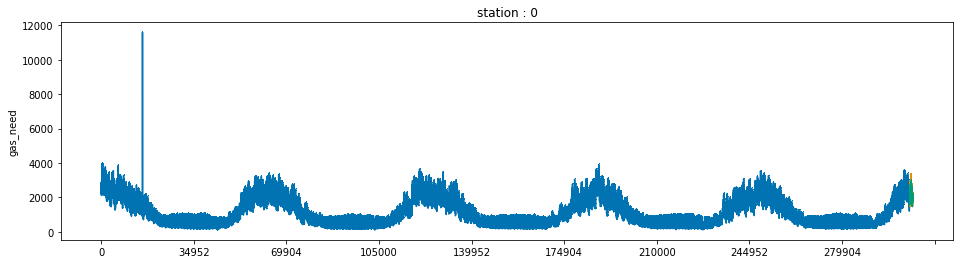

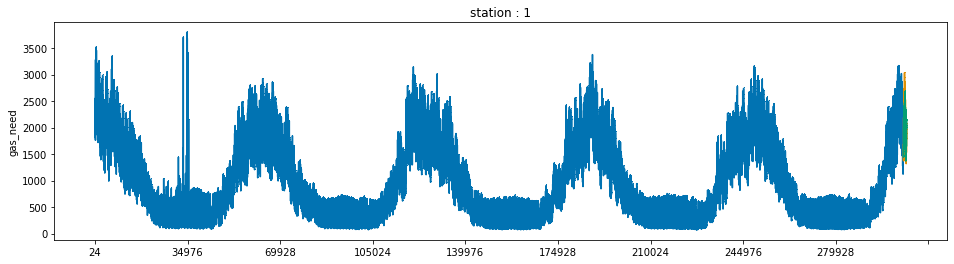

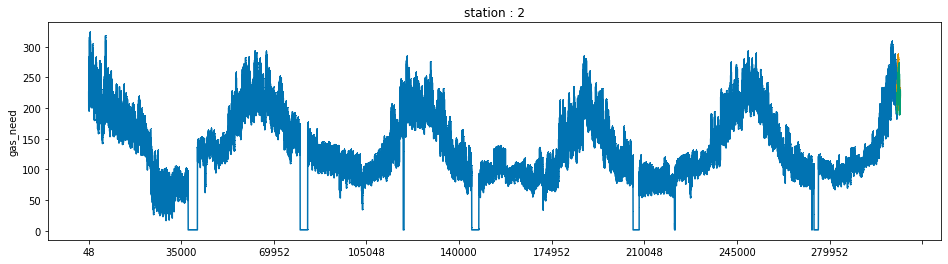

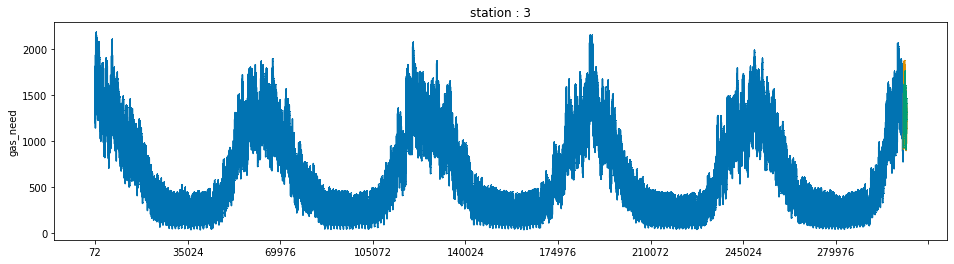

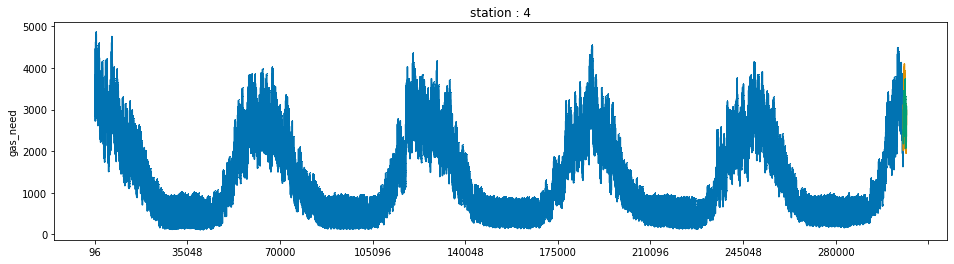

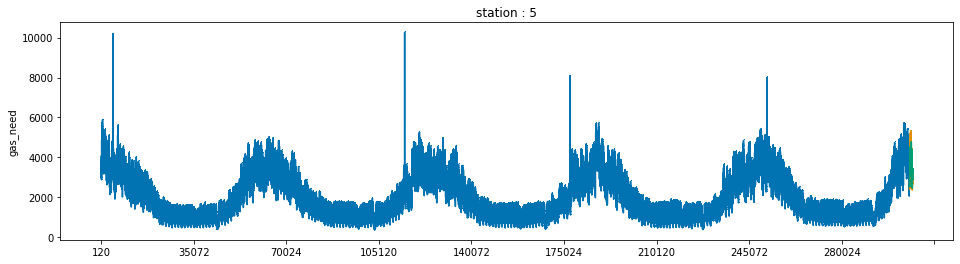

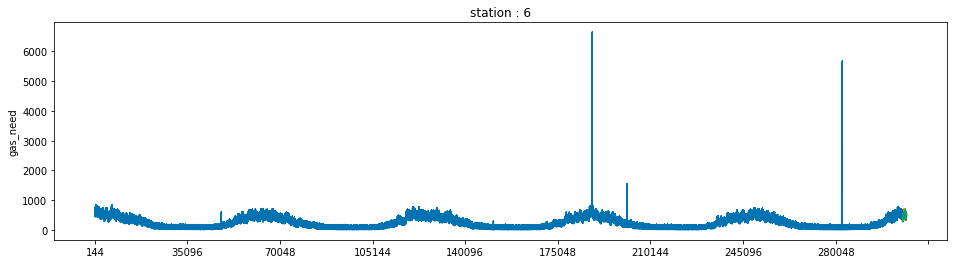

In [ ]:
for i in range(7):
  temp = pd.Series(xgb_sets[i].predict(x_valid_sets[i]))
  temp.index = y_valid_sets[i].index
  plot_series(y_train_sets[i],y_valid_sets[i], temp,markers = [',',',',','])
  plt.title("station : "+str(i))

In [ ]:
for i in range(7):
  print("building {} || best score : {}".format(i+1, scores[i]))
  pred = xgb_sets[i].predict(x_test_sets[i])
  submission.iloc[2160*i:2160*(i+1),1] = pred

building 1 || best score : 3.223375973769245
building 2 || best score : 3.6467243481583616
building 3 || best score : 1.965790716072524
building 4 || best score : 3.468061288268323
building 5 || best score : 3.213420783983613
building 6 || best score : 2.931334786332616
building 7 || best score : 3.1340643674703066


In [ ]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,2032.084595
1,2019-01-01 02 A,1888.815918
2,2019-01-01 03 A,1844.748291
3,2019-01-01 04 A,1844.748291
4,2019-01-01 05 A,1893.892090
...,...,...
15115,2019-03-31 20 H,432.376648
15116,2019-03-31 21 H,432.376648
15117,2019-03-31 22 H,423.709229
15118,2019-03-31 23 H,393.476318


In [ ]:
submission.to_csv("/content/drive/MyDrive/XGB_PRATICE.csv", index = False)